In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import make_grid
from torchsummary import summary
import itertools
import os

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d balraj98/horse2zebra-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset
License(s): other
 85% 95.0M/111M [00:01<00:00, 78.4MB/s]
100% 111M/111M [00:01<00:00, 92.4MB/s] 


In [3]:
!unzip -q '/content/horse2zebra-dataset.zip' -d '/content/'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Configurations

In [5]:
horse_path = "./trainA"
zebra_path = "./trainB"
img_shape = 256
batch_size = 16

## Dataset and Dataloader

In [6]:
class MyDataset(Dataset):
    def __init__(self, img_dir_A, img_dir_B, transform=None):
        self.img_dir_a = img_dir_A
        self.img_dir_b = img_dir_B
        self.transform = transform
        self.file_list_a = os.listdir(img_dir_A)
        self.file_list_b = os.listdir(img_dir_B)
        self.length_a = len(self.file_list_a)
        self.length_b = len(self.file_list_b)
        self.dataset_length = max(len(self.file_list_a), len(self.file_list_b))

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        img_path_a = os.path.join(self.img_dir_a, self.file_list_a[idx % self.length_a])
        img_path_b = os.path.join(self.img_dir_b, self.file_list_b[idx % self.length_b])
        zebra_img = Image.open(img_path_b).convert("RGB")
        horse_img = Image.open(img_path_a).convert("RGB")
        if self.transform:
            zebra_img = self.transform(zebra_img)
            horse_img = self.transform(horse_img)
        return horse_img, zebra_img

In [7]:
transform = T.Compose([
    T.Resize([img_shape, img_shape]),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [8]:
train_dataset = MyDataset(horse_path, zebra_path, transform=transform)

In [9]:
print(len(train_dataset))

1334


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
def plot_imgs(dataloader, n_imgs=9):
    img_a, img_b = next(iter(dataloader))
    img_a = make_grid(img_a[:9], int(n_imgs**0.5), int(n_imgs**0.5), normalize=True)
    img_b = make_grid(img_b[:9], int(n_imgs**0.5), int(n_imgs**0.5), normalize=True)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(img_a.permute(1,2,0).numpy())
    plt.title("Horse")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(img_b.permute(1,2,0).numpy())
    plt.title("Zebra")
    plt.axis("off")

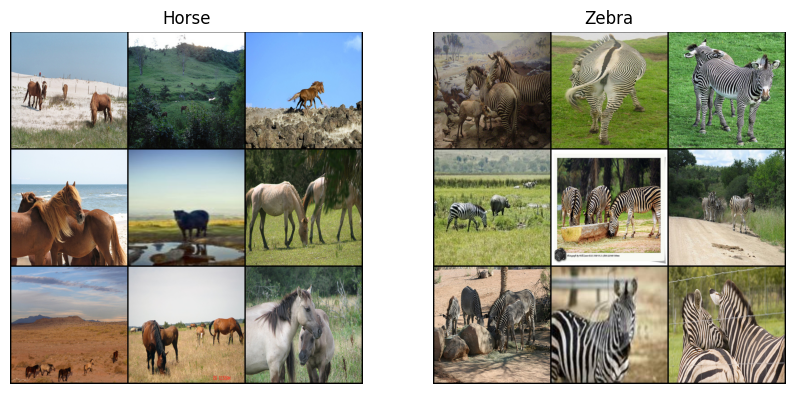

In [14]:
plot_imgs(train_dataloader)

## Discriminator

In [15]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=4,
                stride=stride, padding=1,
                padding_mode="reflect", bias=True
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.layers = [
            Block(3, 64, 2),
            Block(64, 128, 2),
            Block(128, 256, 2),
            Block(256, 512, 1),
            Block(512, 1, 1)
        ]
        self.model = nn.Sequential(*self.layers)
    def forward(self, x):
        return self.model(x)

In [17]:
summary(Discriminator().to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
    InstanceNorm2d-2         [-1, 64, 128, 128]               0
         LeakyReLU-3         [-1, 64, 128, 128]               0
             Block-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-6          [-1, 128, 64, 64]               0
         LeakyReLU-7          [-1, 128, 64, 64]               0
             Block-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 256, 32, 32]         524,544
   InstanceNorm2d-10          [-1, 256, 32, 32]               0
        LeakyReLU-11          [-1, 256, 32, 32]               0
            Block-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-14          [-1, 512,

## Generator

In [18]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, act=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, padding_mode="reflect"
            ),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if act else nn.Identity()
        )

    def forward(self, x):
        return self.layer(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, act=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,kernel_size=kernel_size,
                stride=stride, padding=padding,
                output_padding=1
            ),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if act else nn.Identity()
        )
    def forward(self, x):
        return self.layer(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.layer = nn.Sequential(
            DownBlock(channels, channels, kernel_size=3, padding=1, stride=1),
            DownBlock(channels, channels, kernel_size=3, padding=1, stride=1, act=False),
        )

    def forward(self, x):
        return x + self.layer(x)


In [19]:
class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.down_layers = nn.Sequential(
            DownBlock(in_channels, out_channels=64, kernel_size=7, stride=1, padding=3),
            DownBlock(64, out_channels=128, kernel_size=3, stride=2, padding=1),
            DownBlock(128, out_channels=256, kernel_size=3, stride=2, padding=1)
        )
        self.residual_layers = nn.Sequential(
            *[ResidualBlock(256) for _ in range(9)]
        )
        self.up_layers = nn.Sequential(
            UpBlock(256, out_channels=128, kernel_size=3, stride=2, padding=1),
            UpBlock(128, out_channels=64, kernel_size=3, stride=2, padding=1),
        )
        self.out = nn.Sequential(
            nn.Conv2d(64, out_channels=3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.down_layers(x)
        x = self.residual_layers(x)
        x = self.up_layers(x)
        return self.out(x)

In [20]:
summary(Generator().to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
         DownBlock-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
         DownBlock-8        [-1, 128, 128, 128]               0
            Conv2d-9          [-1, 256, 64, 64]         295,168
   InstanceNorm2d-10          [-1, 256, 64, 64]               0
             ReLU-11          [-1, 256, 64, 64]               0
        DownBlock-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-14          [-1, 256,

## Training

In [24]:
def train(generator_h, generator_z, discriminator_h, discriminator_z, epochs, batch_size, lr, train_dataloader):
    history = {'G_loss':[], 'D_loss':[]}
    mse = nn.MSELoss()
    l1 = nn.L1Loss()
    g_optimizer = optim.Adam(itertools.chain(generator_h.parameters(), generator_z.parameters()), lr=lr)
    d_optimizer = optim.Adam(itertools.chain(discriminator_h.parameters(), discriminator_z.parameters()), lr=lr)
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    for epoch in range(epochs):
        for i, (horse, zebra) in enumerate(train_dataloader):
            horse = horse.to(device)
            zebra = zebra.to(device)
            with torch.cuda.amp.autocast():
              fake_zebra = generator_z(horse)
              d_z_real = discriminator_z(zebra)
              d_z_fake = discriminator_z(fake_zebra.detach())
              d_z_loss = mse(d_z_real, torch.ones_like(d_z_real)) + mse(d_z_fake, torch.zeros_like(d_z_fake))

              fake_horse = generator_h(zebra)
              d_h_real = discriminator_h(horse)
              d_h_fake = discriminator_h(fake_horse.detach())
              d_h_loss = mse(d_h_real, torch.ones_like(d_h_real)) + mse(d_h_fake, torch.zeros_like(d_h_fake))

              d_loss = (d_z_loss + d_h_loss)/2

            d_optimizer.zero_grad()
            d_scaler.scale(d_loss).backward()
            d_scaler.step(d_optimizer)
            d_scaler.update()

            with torch.cuda.amp.autocast():
              l_z = discriminator_z(fake_zebra)
              l_h = discriminator_h(fake_horse)
              g_loss = mse(l_z, torch.ones_like(l_z)) + mse(l_h, torch.ones_like(l_h))
              cycle_loss = l1(generator_z(generator_h(zebra)), zebra) + l1(generator_h(generator_z(horse)), horse)
              total_loss = g_loss + cycle_loss

            g_optimizer.zero_grad()
            g_scaler.scale(total_loss).backward()
            g_scaler.step(g_optimizer)
            g_scaler.update()

            if i%10 == 0:
                with torch.inference_mode():
                    history['G_loss'].append(total_loss.item())
                    history['D_loss'].append(d_loss.item())
                    print(f"Epoch {epoch} : Step : {i} Discriminator : {history['D_loss']} Generator : {history['G_loss']}")

In [25]:
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

generator_g.to(device)
generator_f.to(device)
discriminator_x.to(device)
discriminator_y.to(device)

Discriminator(
  (model): Sequential(
    (0): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): Block(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): Block(
      (conv): Sequential(
        (0): Conv2d(25

In [ ]:
train(generator_g, generator_f, discriminator_x, discriminator_y, epochs=5, batch_size=batch_size, lr=2e-4, train_dataloader=train_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
